# 404 DATA NOT FOUND
Yuu Ricardo Akachi Tanaka

Cecilia Palau Dávila

Juan Carlos Sala Pulido

Carlos Cuilty Villarreal

## 0. Importamos librerías

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from difflib import get_close_matches
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# 1. Cargar bases de datos

Para nuestro proyecto solo se estará utilizando la base de datos de `base_transacciones_final.csv`, debido a que para nuestros modelos no son necesarios los datos personales de los clientes.

In [97]:
# Cargar las bases de datos
#clientes_path = "base_clientes_final.csv"
transacciones_path = "base_transacciones_final.csv"

#df_clientes = pd.read_csv(clientes_path)
df_transacciones = pd.read_csv(transacciones_path)

# Revisar estructura inicial
#df_clientes.head() 
df_transacciones.head()

,id,fecha,comercio,giro_comercio,tipo_venta,monto
0,91477f382c3cf63ab5cd9263b502109243741158,2022-01-02,AMAZON,COMERCIOS ELECTRONICOS (VTAS POR INTERNET),digital,5.99
1,91477f382c3cf63ab5cd9263b502109243741158,2022-01-05,RAPPI,SERVICIOS EMPRESARIALES - NO CLASIFICADOS,digital,13.01
2,91477f382c3cf63ab5cd9263b502109243741158,2022-01-05,RAPPI,SERVICIOS EMPRESARIALES - NO CLASIFICADOS,digital,15.84
3,91477f382c3cf63ab5cd9263b502109243741158,2022-01-05,AMAZON,COMERCIOS ELECTRONICOS (VTAS POR INTERNET),digital,8.17
4,91477f382c3cf63ab5cd9263b502109243741158,2022-01-05,AMAZON,COMERCIOS ELECTRONICOS (VTAS POR INTERNET),digital,2.54


# 2. Exploración de los datos (EDA)

## 2.1 Información general del dataframe

In [98]:
# Dimensiones del DataFrame
print("Dimensiones:", df_transacciones.shape)

Dimensiones: (346011, 6)


Contiene 346,011 transacciones (registros) y 6 features (variables)

In [ ]:
# Columnas del DataFrame
print(list(df_transacciones.columns))

['id', 'fecha', 'comercio', 'giro_comercio', 'tipo_venta', 'monto']


Significado de las variables:
* `id`: Identificador único del cliente
* `fecha`: Fecha en la que se realizó la transacción
* `comercio`: Nombre del comercio
* `giro_comercio`: Nombre del código MCC del comercio
* `tipo_venta`: Indica si una transacción fue física o digital
* `monto`: Importe de la transacción

In [101]:
# Tipos de datos y valores nulos
print("\nInformación general:")
print(df_transacciones.info())

print("\nSuma de valores nulos por columna:")
print(df_transacciones.isnull().sum())


Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346011 entries, 0 to 346010
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             346011 non-null  object 
 1   fecha          346011 non-null  object 
 2   comercio       346011 non-null  object 
 3   giro_comercio  340423 non-null  object 
 4   tipo_venta     346011 non-null  object 
 5   monto          346011 non-null  float64
dtypes: float64(1), object(5)
memory usage: 15.8+ MB
None

Suma de valores nulos por columna:
id                  0
fecha               0
comercio            0
giro_comercio    5588
tipo_venta          0
monto               0
dtype: int64


Vemos que el tipo de dato de las variables fecha, comercio, giro_comercio y tipo_venta están mal, estos tienen que ser de la siguiente manera:
* `fecha`: datetime
* `comercio`: category
* `giro_comercio`: category
* `tipo_venta`: category

Asimismo observamos que la única variable que contiene valores nulos es la de `giro_comercio` con 5588 valores nulos.

## 2.2 Análisis de variables numéricas

In [102]:
# Estadísticas descriptivas para columnas numéricas
print("\nEstadísticas descriptivas (numéricas):")
print(df_transacciones.describe())


Estadísticas descriptivas (numéricas):
               monto
count  346011.000000
mean       42.290700
std        94.554414
min         1.390000
25%         9.320000
50%        17.930000
75%        39.430000
max      2297.880000


Podemos observar que no hay valores imposibles ya que se trata de dinero y no hay valores negativos. También vemos que el máximo es de 2297.88 pesos por lo que sí es posible.

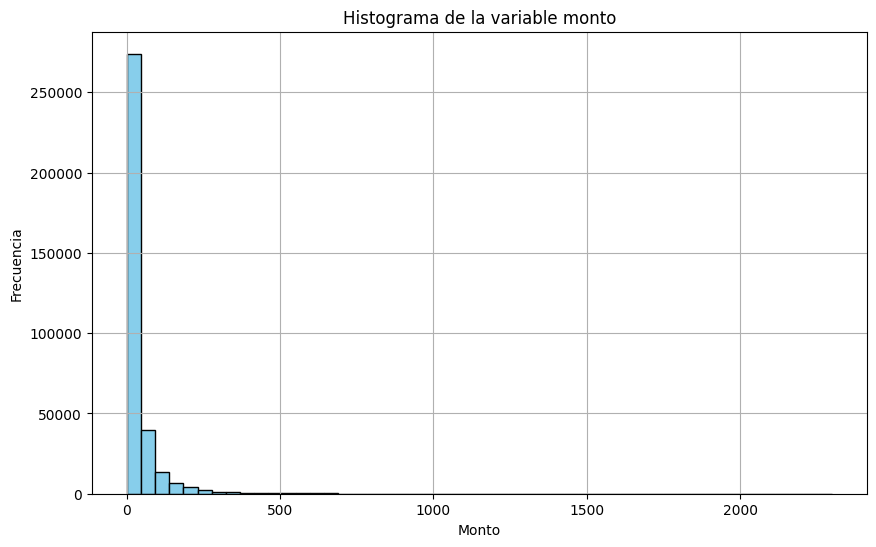

In [103]:
plt.figure(figsize=(10, 6))
plt.hist(df_transacciones['monto'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma de la variable monto')
plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Viendo la gráfica vemos que tiene una distribución sesgada a la derecha, también hay una alta concentración entre 0 y 100. Asimismo, se puede observar que hay outliers y que no es una distribución normal.

## 2.3 Análisis de variables categóricas

In [107]:
# Estadísticas descriptivas para columnas categóricas
print("\nEstadísticas descriptivas (categóricas seleccionadas):")
print(df_transacciones[["comercio", "giro_comercio", "tipo_venta"]].describe())


Estadísticas descriptivas (categóricas seleccionadas):
       comercio giro_comercio tipo_venta
count    346011        340423     346011
unique       97            82          2
top        UBER     AGREGADOR    digital
freq      40263         56048     235487


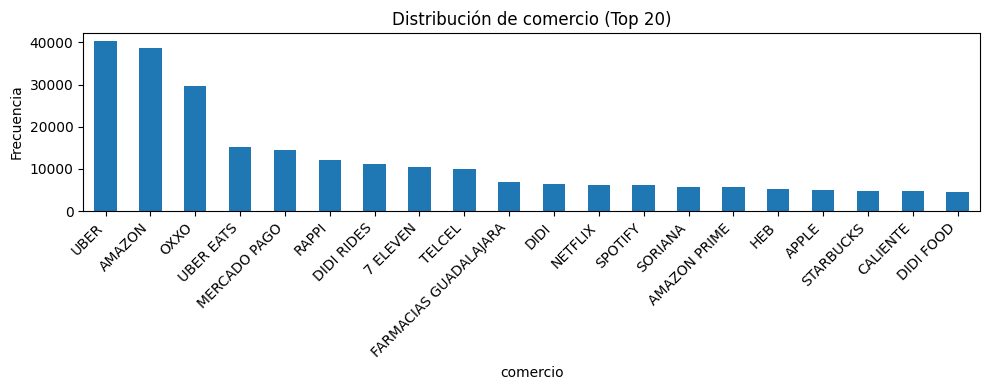

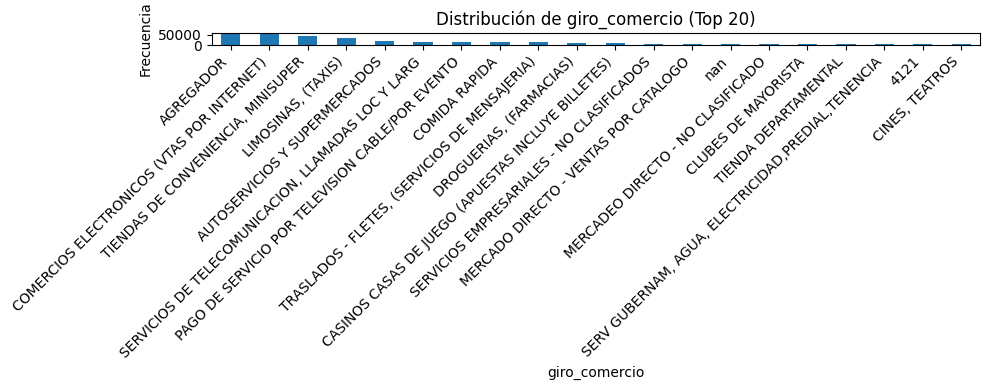

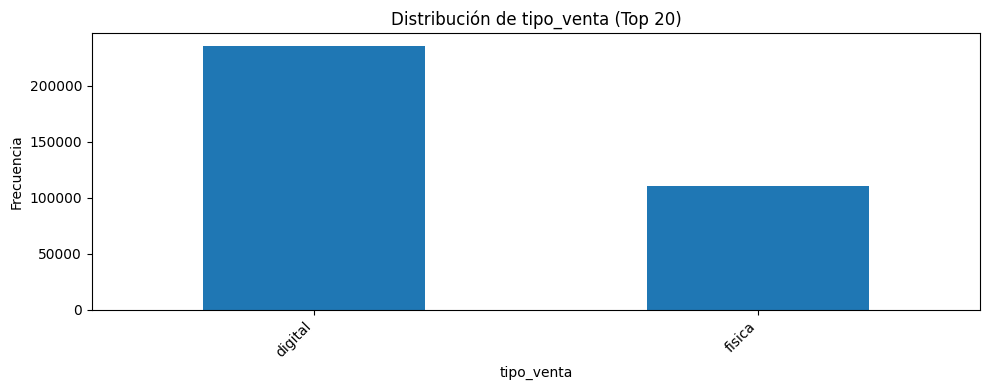

In [108]:
# Graficar gráficas de barra para las variables categóricas de df_transacciones
categoricas = ["comercio", "giro_comercio", "tipo_venta"]

for col in categoricas:
    plt.figure(figsize=(10, 4))
    df_transacciones[col].value_counts(dropna=False).head(20).plot(kind='bar')
    plt.title(f'Distribución de {col} (Top 20)')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Podemos observar que UBER, AMAZON y OXXO son lo que tienen más transacciones dentro de todos los clientes. También vemos que la mayoría de las transacciones ocurrieron de manera digital.

## 2.4 Valores nulos

In [94]:
# Conteo de valores nulos por columna
print("\nValores nulos por columna:")
print(df_transacciones.isnull().sum())


Valores nulos por columna:
id                  0
fecha               0
comercio            0
giro_comercio    5588
tipo_venta          0
monto               0
dtype: int64


Observamos que la única variable que contiene valores nulos es la de `giro_comercio` con 5588 valores nulos.

# 3. Limpieza de datos

## 3.1 Corregir tipos de datos

Se corrigen los tipos de datos de cada variable como se mencionó anteriormente.

In [111]:
# Fecha a Datetime
df_transacciones["fecha"] = pd.to_datetime(df_transacciones["fecha"])

In [112]:
# Categoricas
df_transacciones["comercio"] = df_transacciones["comercio"].astype("category")
df_transacciones["giro_comercio"] = df_transacciones["giro_comercio"].astype("category")
df_transacciones["tipo_venta"] = df_transacciones["tipo_venta"].astype("category")

In [113]:
df_transacciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346011 entries, 0 to 346010
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             346011 non-null  object        
 1   fecha          346011 non-null  datetime64[ns]
 2   comercio       346011 non-null  category      
 3   giro_comercio  340423 non-null  category      
 4   tipo_venta     346011 non-null  category      
 5   monto          346011 non-null  float64       
dtypes: category(3), datetime64[ns](1), float64(1), object(1)
memory usage: 8.9+ MB


Observamos que ya están corregidas

## 3.2 Checar inconsistencias en categoricas

Especialmente, se buscó inconsistencias en los comercios ya que es una variable sumamente importante para nuestro análisis futuro.

In [114]:
df_transacciones['comercio'].unique()

['AMAZON', 'RAPPI', 'CFE', 'OXXO', 'FARMACIAS DEL AHORRO', ..., 'METROBUS', 'SMART FIT', 'GOOGLE AMAZON MOBILE', 'AUDIBLE', 'ROKU']
Length: 97
Categories (97, object): ['7 ELEVEN', '7ELEVEN', 'ADOBE', 'ALIEXPRESS', ..., 'URBANI', 'VIX', 'WAL-MART', 'WALMART']

Vemos que hay faltas de ortografía en algunas como `7 ELEVEN` y `7ELEVEN`. Para checar estas inconsistencias se utilizó la librería difflib que checa textos similares.

In [115]:
# Lista única de comercios (sin nulos)
comercios_unicos = df_transacciones['comercio'].dropna().unique().tolist()

# Crear un diccionario de mapeo para reemplazo basado en similitud
reemplazos = {}
visitados = set()

for comercio in comercios_unicos:
    if comercio in visitados:
        continue
    similares = get_close_matches(comercio, comercios_unicos, n=10, cutoff=0.88)
    if len(similares) > 1:
        base = similares[0]  # el primer elemento como referencia
        for s in similares:
            reemplazos[s] = base
            visitados.add(s)

# Aplicar los reemplazos en el DataFrame
df_transacciones['comercio'] = df_transacciones['comercio'].map(reemplazos).fillna(df_transacciones['comercio'])

# Mostrar los mapeos realizados
df_reemplazos = pd.DataFrame(list(reemplazos.items()), columns=['Original', 'Reemplazado'])

df_reemplazos

,Original,Reemplazado
0,7 ELEVEN,7 ELEVEN
1,7ELEVEN,7 ELEVEN
2,MERCADO PAGO,MERCADO PAGO
3,MERCADOPAGO,MERCADO PAGO
4,WALMART,WALMART
5,WAL-MART,WALMART
6,TOTALPLAY,TOTALPLAY
7,TOTAL PLAY,TOTALPLAY
8,DIDI FOOD,DIDI FOOD
9,DIDIFOOD,DIDI FOOD


El DataFrame anterior nos puesta las variables que tuvieron similitudes y cómo fueron reemplazados.

In [116]:
df_transacciones['comercio'].unique()

array(['AMAZON', 'RAPPI', 'CFE', 'OXXO', 'FARMACIAS DEL AHORRO',
       '7 ELEVEN', 'SORIANA', 'HEB', 'LIVERPOOL', 'SPOTIFY',
       'SUPERCENTER', 'COSTCO', 'OXXO GAS', 'UBER', 'STARBUCKS',
       'UBER EATS', 'SERV AGUA DREN', 'AMAZON PRIME', 'UNDOSTRES',
       'MERCADO PAGO', 'RAPPIPRO', 'WALMART', 'TELCEL', 'TELMEX',
       'CRUNCHYROLL', 'FARMACIAS GUADALAJARA', 'IZZI', 'CINEPOLIS',
       'DISNEY PLUS', 'BAIT', 'NAYAX', 'CARLS JR', 'APPLE', 'TOTALPLAY',
       'SAMS CLUB', 'NETFLIX', 'MELIMAS', 'MICROSOFT', 'MAX', 'TULOTERO',
       'BAE', 'DIDI RIDES', 'GOOGLE YOUTUBEPREMIUM', 'ALLIANZ MEXICO',
       'ITUNES', 'SMART', 'ALSUPER', 'UBRPAGOSMEX', 'PARCO', 'FACEBOOK',
       'TEMU', 'CHEDRAUI', 'COPPEL', 'FARMACIAS SIMILARES', 'GOOGLE',
       'MI ATT', 'SUPERAMA', 'ROTOPLAS', 'TOTAL PASS', 'ALIEXPRESS',
       'CALIENTE', 'DIDI', 'DIDI FOOD', 'CASHI ECOMMERCE', 'GOOGLE ONE',
       'APLAZO', 'SOFT RAPPI', 'OPENAI', 'VIX', 'SHEIN', 'COSTCO GAS',
       'AT&T', 'SMARTFIT', 'GOOGLE

Se checó de nuevo manualmente para ver si hay más errores que tal vez no se pudieron identificar. En este caso vemos que hay valores de `ATT` y `AT&T` esto es una inconsistencia, por lo que lo reemplazamos manualmente.

In [117]:
df_transacciones['comercio'] = df_transacciones['comercio'].replace('ATT', 'AT&T')

Ahora sí todos los valores de `comercio` están bien.

In [118]:
df_transacciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346011 entries, 0 to 346010
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             346011 non-null  object        
 1   fecha          346011 non-null  datetime64[ns]
 2   comercio       346011 non-null  object        
 3   giro_comercio  340423 non-null  category      
 4   tipo_venta     346011 non-null  category      
 5   monto          346011 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(2)
memory usage: 11.2+ MB


Al checar otra vez el tipo de dato de `comercio` vemos que se convirtió en object, por lo que lo volvemos a cambiar a categórica.

In [119]:
df_transacciones["comercio"] = df_transacciones["comercio"].astype("category")
df_transacciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346011 entries, 0 to 346010
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             346011 non-null  object        
 1   fecha          346011 non-null  datetime64[ns]
 2   comercio       346011 non-null  category      
 3   giro_comercio  340423 non-null  category      
 4   tipo_venta     346011 non-null  category      
 5   monto          346011 non-null  float64       
dtypes: category(3), datetime64[ns](1), float64(1), object(1)
memory usage: 8.9+ MB


## 3.3 Guardar datos limpios

Ahora la base de datos está lista para ser exportada y ser utilizada en nuestro frontend. En este caso se decidió guardó la base de datos en formato `.csv`.

In [120]:
df_transacciones.to_csv("df_transacciones.csv", index=False)

# 4. Preprocesamiento de los datos

## 4.1 Feature Engineering

Como primer paso de este proyecto necesitamos detectar si un cliente realiza compras recurrentes en un mismo comercio. Para esto primeramente necesitamos agrupar los datos por cliente y comercio. Y para cada transaccion por cliente y comercio calcula lo siguiente:

* `count`: número total de transacciones.
* `min`: fecha de la primera compra.
* `max`: fecha de la última compra.
* `mean`: monto promedio gastado.
* `std`: desviación estándar del monto (variabilidad).

Estas estadísticas resumen el comportamiento histórico del cliente con cada comercio. Nos permiten entender:

* La frecuencia (cuántas veces ha comprado).
* La duración del historial (desde cuándo hasta cuándo).
* La consistencia en el monto (si gasta siempre lo mismo o varía).

In [121]:
# Agrupar por cliente y comercio
frecuencia = (
    df_transacciones.groupby(["id", "comercio"])
    .agg({
        "fecha": ["count", "min", "max"],
        "monto": ["mean", "std"]
    })
).reset_index()

C:\Users\yuura\AppData\Local\Temp\ipykernel_24760\369699861.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_transacciones.groupby(["id", "comercio"])


In [122]:
# Renombrar columnas para facilitar análisis posterior
frecuencia.columns = ["id", "comercio", "num_tx", "fecha_min", "fecha_max", "monto_prom", "monto_std"]

También es necesario calcular el promedio de días entre compras para encontrar regularidad del patrón de compra. Esto lo calculamos de la siguiente manera: 

$dias\_entre = \frac{fecha\_max - fecha\_min}{num\_tx - 1}$

Esto refleja la regularidad del patrón de compra. Si el cliente compra cada ~30 días, por ejemplo, indica comportamiento recurrente. Si pasan 150 días entre compras, probablemente no lo sea.

In [123]:
# Calcular días entre transacciones
frecuencia["dias_entre"] = (frecuencia["fecha_max"] - frecuencia["fecha_min"]).dt.days / (frecuencia["num_tx"] - 1)
frecuencia["dias_entre"].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\yuura\AppData\Local\Temp\ipykernel_24760\2852806674.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  frecuencia["dias_entre"].replace([np.inf, -np.inf], np.nan, inplace=True)


### **RECURRENTE O NO**

Para calcular si un comercio es recurrente o no, se decidió trabajar con una heurística. Es decir, se aplicó una regla lógica para clasificar si un cliente tiene comportamiento recurrente con un comercio. Esto debido a que es una forma rápida, transparente y explicable de segmentar los datos antes de aplicar modelos complejos. Aísla los comportamientos consistentes, donde sí tiene sentido hacer predicciones.

Las reglas que se decidieron para ver si es recurrente o no son las siguientes:
* *Frecuencia mínima*: al menos 3 compras (para tener historial suficiente).
* *Regularidad temporal*: el promedio entre compras es ≤ 45 días.
* *Estabilidad en el monto*: la desviación estándar del monto debe ser < 30% del promedio, lo cual sugiere que gasta más o menos lo mismo cada vez.

In [124]:
# Aplicar heurística
frecuencia["es_recurrente"] = (
    (frecuencia["num_tx"] >= 3) &
    (frecuencia["dias_entre"] <= 45) &
    (frecuencia["monto_std"] < 0.3 * frecuencia["monto_prom"])
)

frecuencia

,id,comercio,num_tx,fecha_min,fecha_max,monto_prom,monto_std,dias_entre,es_recurrente
0,003d9abe467a91847d566cf455bd2d7d6c8f7e75,7 ELEVEN,0,NaT,NaT,NaN,NaN,NaN,False
1,003d9abe467a91847d566cf455bd2d7d6c8f7e75,ADOBE,0,NaT,NaT,NaN,NaN,NaN,False
2,003d9abe467a91847d566cf455bd2d7d6c8f7e75,ALIEXPRESS,0,NaT,NaT,NaN,NaN,NaN,False
3,003d9abe467a91847d566cf455bd2d7d6c8f7e75,ALLIANZ MEXICO,0,NaT,NaT,NaN,NaN,NaN,False
4,003d9abe467a91847d566cf455bd2d7d6c8f7e75,ALSUPER,0,NaT,NaT,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...
88995,ff67da037fae796809be0e36fb9cdd0e191c38a4,UBRPAGOSMEX,0,NaT,NaT,NaN,NaN,NaN,False
88996,ff67da037fae796809be0e36fb9cdd0e191c38a4,UNDOSTRES,0,NaT,NaT,NaN,NaN,NaN,False
88997,ff67da037fae796809be0e36fb9cdd0e191c38a4,URBANI,0,NaT,NaT,NaN,NaN,NaN,False
88998,ff67da037fae796809be0e36fb9cdd0e191c38a4,VIX,0,NaT,NaT,NaN,NaN,NaN,False


Ahora se filtra el dataset original de transacciones para quedar únicamente con los comercios recurrentes, según la heurística anterior, y así construir un historial limpio y relevante para modelado.

In [125]:
# Filtrar solo los comercios recurrentes
comercios_recurrentes = frecuencia[frecuencia["es_recurrente"]]

# Unir de vuelta con las transacciones para obtener el historial completo de esos comercios
df_recurrentes = df_transacciones.merge(
    comercios_recurrentes[["id", "comercio"]],
    on=["id", "comercio"],
    how="inner"
)

# Ordenar por cliente, comercio y fecha
df_recurrentes = df_recurrentes.sort_values(by=["id", "comercio", "fecha"])
df_recurrentes

,id,fecha,comercio,giro_comercio,tipo_venta,monto
29944,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-01-16,AMAZON PRIME,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,11.62
29945,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-01-16,AMAZON PRIME,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,11.62
29951,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-02-16,AMAZON PRIME,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,11.62
29954,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-03-16,AMAZON PRIME,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,11.62
29967,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-04-16,AMAZON PRIME,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,11.62
...,...,...,...,...,...,...
55317,ff67da037fae796809be0e36fb9cdd0e191c38a4,2023-01-15,MEGACABLE,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,94.44
55263,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-01-09,STARBUCKS,COMIDA RAPIDA,digital,17.47
55265,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-01-26,STARBUCKS,COMIDA RAPIDA,digital,11.73
55268,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-02-14,STARBUCKS,COMIDA RAPIDA,digital,17.47


### Construir dataset de entrenamiento

Una vez que se identificaron los comercios recurrentes para cada cliente, el siguiente paso fue generar un dataset estructurado para entrenar modelos de predicción. Este conjunto de datos debía reflejar el comportamiento temporal y financiero del cliente con cada comercio, permitiendo estimar con cierta precisión tanto la fecha como el monto de su próxima compra.

Para lograrlo, primero se aseguró que las transacciones estuvieran ordenadas cronológicamente por cliente y comercio. Esto es fundamental porque muchas de las variables que se calculan dependen del orden temporal, como el tiempo entre compras o la evolución del gasto.

In [126]:
df_recurrentes = df_recurrentes.sort_values(by=["id", "comercio", "fecha"])

A continuación, se generaron las variables objetivo (targets) para el modelo. Para cada transacción, se identificó la fecha y el monto de la siguiente compra, utilizando la función `shift(-1)` dentro de cada grupo de cliente–comercio. Esto permitió construir dos columnas clave: `fecha_siguiente` y `monto_siguiente`. De ahí se derivó la variable `dias_hasta_siguiente`, que representa el número de días que transcurren entre la compra actual y la próxima, convirtiéndose así en el target para el modelo temporal.

In [127]:
# Agrupar para crear targets de próxima fecha y próximo monto
df_recurrentes["fecha_siguiente"] = df_recurrentes.groupby(["id", "comercio"])["fecha"].shift(-1)
df_recurrentes["monto_siguiente"] = df_recurrentes.groupby(["id", "comercio"])["monto"].shift(-1)

# Calcular días hasta la siguiente compra
df_recurrentes["dias_hasta_siguiente"] = (df_recurrentes["fecha_siguiente"] - df_recurrentes["fecha"]).dt.days

C:\Users\yuura\AppData\Local\Temp\ipykernel_24760\2549825994.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_recurrentes["fecha_siguiente"] = df_recurrentes.groupby(["id", "comercio"])["fecha"].shift(-1)
C:\Users\yuura\AppData\Local\Temp\ipykernel_24760\2549825994.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_recurrentes["monto_siguiente"] = df_recurrentes.groupby(["id", "comercio"])["monto"].shift(-1)


Además, se calcularon diversas features históricas para enriquecer el modelo. Por ejemplo, se calculó `dias_desde_ultima`, que mide el tiempo transcurrido desde la compra anterior, útil para capturar la regularidad del patrón de consumo. También se añadieron estadísticas acumuladas como `media_monto_hist` y `std_monto_hist` mediante funciones de `expanding()`, las cuales capturan el promedio y la variabilidad del monto gastado hasta ese punto, excluyendo la transacción actual. Esto permite al modelo comprender si el cliente tiene un gasto consistente o fluctuante.

In [128]:
# Calcular días desde la última compra
df_recurrentes["fecha_anterior"] = df_recurrentes.groupby(["id", "comercio"])["fecha"].shift(1)
df_recurrentes["dias_desde_ultima"] = (df_recurrentes["fecha"] - df_recurrentes["fecha_anterior"]).dt.days

# Calcular estadísticas históricas previas (media y std del monto)
df_recurrentes["media_monto_hist"] = df_recurrentes.groupby(["id", "comercio"])["monto"].expanding().mean().reset_index(level=[0,1], drop=True)
df_recurrentes["std_monto_hist"] = df_recurrentes.groupby(["id", "comercio"])["monto"].expanding().std().reset_index(level=[0,1], drop=True)

C:\Users\yuura\AppData\Local\Temp\ipykernel_24760\885486450.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_recurrentes["fecha_anterior"] = df_recurrentes.groupby(["id", "comercio"])["fecha"].shift(1)
C:\Users\yuura\AppData\Local\Temp\ipykernel_24760\885486450.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_recurrentes["media_monto_hist"] = df_recurrentes.groupby(["id", "comercio"])["monto"].expanding().mean().reset_index(level=[0,1], drop=True)
C:\Users\yuura\AppData\Local\Temp\ipykernel_24760\885486450.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True

Finalmente, se incluyó la variable `num_tx_cliente_comercio`, que cuenta cuántas transacciones ha tenido un cliente con un comercio determinado. Esta variable representa la profundidad del historial disponible, lo cual puede ser útil para ponderar la confianza del modelo en sus predicciones.

In [129]:
# Contar número de transacciones acumuladas por cliente-comercio
df_recurrentes["num_tx_cliente_comercio"] = df_recurrentes.groupby(["id", "comercio"]).cumcount() + 1

C:\Users\yuura\AppData\Local\Temp\ipykernel_24760\2776515854.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_recurrentes["num_tx_cliente_comercio"] = df_recurrentes.groupby(["id", "comercio"]).cumcount() + 1


Para mantener la integridad del modelo supervisado, se eliminaron todas las filas que no tuvieran valores en las variables objetivo (es decir, las últimas compras de cada serie), ya que no hay manera de saber qué ocurrió después de ellas.

In [130]:
# Eliminar transacciones sin target (última de cada cliente-comercio)
df_modelo = df_recurrentes.dropna(subset=["dias_hasta_siguiente", "monto_siguiente", "dias_desde_ultima"])

df_modelo

,id,fecha,comercio,giro_comercio,tipo_venta,monto,fecha_siguiente,monto_siguiente,dias_hasta_siguiente,fecha_anterior,dias_desde_ultima,media_monto_hist,std_monto_hist,num_tx_cliente_comercio
29945,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-01-16,AMAZON PRIME,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,11.62,2022-02-16,11.62,31.0,2022-01-16,0.0,11.620000,0.000000,2
29951,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-02-16,AMAZON PRIME,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,11.62,2022-03-16,11.62,28.0,2022-01-16,31.0,11.620000,0.000000,3
29954,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-03-16,AMAZON PRIME,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,11.62,2022-04-16,11.62,31.0,2022-02-16,28.0,11.620000,0.000000,4
29967,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-04-16,AMAZON PRIME,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,11.62,2022-05-16,11.62,30.0,2022-03-16,31.0,11.620000,0.000000,5
29979,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-05-16,AMAZON PRIME,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,11.62,2022-06-16,11.62,31.0,2022-04-16,30.0,11.620000,0.000000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55310,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-12-04,MEGACABLE,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,91.00,2022-12-10,91.00,6.0,2022-11-13,21.0,86.460526,2.408410,19
55312,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-12-10,MEGACABLE,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,91.00,2022-12-13,91.00,3.0,2022-12-04,6.0,86.687500,2.554505,20
55313,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-12-13,MEGACABLE,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,91.00,2023-01-15,94.44,33.0,2022-12-10,3.0,86.892857,2.661733,21
55265,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-01-26,STARBUCKS,COMIDA RAPIDA,digital,11.73,2022-02-14,17.47,19.0,2022-01-09,17.0,14.600000,4.058793,2


Con esto convertimos los registros transaccionales en un dataset estructurado y enriquecido, listo para alimentar modelos de aprendizaje automático orientados a la predicción temporal y financiera de los clientes.

## 5. Modelo predictivo para días esperadas para siguiente compra

### 5.1 Features y target

Se seleccionaron las variables explicativas (features) que serán utilizadas para entrenar el modelo. Estas variables reflejan el comportamiento pasado del cliente con un comercio:
* `dias_desde_ultima`: número de días desde la última compra.
* `monto`: valor de la compra actual.
* `media_monto_hist`: promedio acumulado del monto gastado hasta el momento.
* `std_monto_hist`: variabilidad en los montos pasados.
* `num_tx_cliente_comercio`: número total de transacciones previas entre el cliente y ese comercio.

Estas características fueron elegidas porque tienen una relación directa o indirecta con la probabilidad de recurrencia temporal de las compras. El target o variable objetivo es `dias_hasta_siguiente`, es decir, el número de días que pasaron entre la compra actual y la siguiente — esta es la variable que se desea predecir.


In [131]:
# Seleccionar las columnas numéricas para entrenar
features = [
    "dias_desde_ultima",
    "monto",
    "media_monto_hist",
    "std_monto_hist",
    "num_tx_cliente_comercio"
]
target = "dias_hasta_siguiente"

### 5.2 Train y test

Se utilizó 80% para entrenamiento y 20% para prueba

In [132]:
# Preparar datos
X = df_modelo[features].fillna(0)
y = df_modelo[target]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 5.3 Entrenamiento del modelo

Se entrenó un Random Forest Regressor, un modelo de aprendizaje automático basado en árboles de decisión, que es robusto ante datos no lineales, escalas distintas y ruidosos. Se usa como modelo base (baseline) por su rendimiento sólido sin requerir demasiada optimización.

* `n_estimators = 100`: se construyen 100 árboles de decisión.
* `random_state = 42`: asegura resultados reproducibles.



In [133]:
# Entrenar modelo base
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### 5.4 Predicción y Evaluación

Se hace la predicción sobre el conjunto de prueba `X_test`. Posteriormente, se evaluó el rendimiento con dos métricas estándar:
* **MAE (Mean Absolute Error)**: mide el error promedio absoluto en días entre la predicción y la realidad.

* **RMSE (Root Mean Squared Error)**: penaliza más los errores grandes y proporciona una noción de la desviación típica de las predicciones.

In [134]:
# Predecir
y_pred = rf_model.predict(X_test)

# Evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

mae, rmse

(7.497956568888574, np.float64(14.718035101660305))

* MAE de 7.50 días nos indica que, en promedio, el modelo se equivoca por aproximadamente 7 días y medio al predecir cuántos días faltan para la próxima compra de un cliente en un comercio recurrente.

* RMSE de 14.72 días nos indica que hay algunos outliers o errores de predicción grandes que afectan el promedio cuadrático.

### 5.5 Guardar el modelo

Se decidió guardar en formato `.joblib` debido a que es más seguro y además podemos comprimirlo para facilitar el uso del modelo.

In [55]:
# joblib.dump(rf_model, 'rf_model_fecha.joblib', compress=('bz2', 9))

['rf_model_fecha.joblib']

In [76]:
rf_model_fecha = joblib.load('rf_model_fecha.joblib')

## 6. Modelo predictivo para monto esperado para la siguiente compra

### 6.1 Features y target

En este caso se utilizaron los mismos features pero ahora este predice el monto de dinero que el cliente gastará en su próxima transacción recurrente.

Aquí se define la nueva variable objetivo: `monto_siguiente`, que representa el valor monetario de la siguiente compra hecha por el cliente en el mismo comercio.

In [135]:
# Nuevo target: monto de la próxima compra
target_monto = "monto_siguiente"

# Preparar datos
y_monto = df_modelo[target_monto]

### 6.2 Train y test

Se utilizó 80% para entrenamiento y 20% para prueba

In [136]:
# Split con las mismas particiones
X_train_monto, X_test_monto, y_train_monto, y_test_monto = train_test_split(X, y_monto, test_size=0.2, random_state=42)

### 6.3 Entrenamiento del modelo

Se entrena nuevamente un Random Forest Regressor, ahora para predecir montos. Este modelo aprende a mapear las características del historial de compras (días entre transacciones, comportamiento del gasto, número de transacciones, etc.) al valor probable de la próxima compra.

El Random Forest se usa porque:

* Funciona bien con datos tabulares.
* No requiere normalización de datos.
* Es robusto ante outliers y relaciones no lineales.

In [137]:
# Entrenar modelo base
rf_model_monto = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_monto.fit(X_train_monto, y_train_monto)

RandomForestRegressor(random_state=42)

### 6.4 Predicción y Evaluación

Se predice `y_pred_monto` y de igual manera se usan las mismas métricas estándar: 
* **MAE (Mean Absolute Error)**: representa el error promedio (en pesos) entre el monto predicho y el real.

* **RMSE (Root Mean Squared Error)**: penaliza más los errores grandes y refleja la desviación estándar de los errores.

In [138]:
# Predecir
y_pred_monto = rf_model_monto.predict(X_test_monto)

# Evaluación
mae_monto = mean_absolute_error(y_test_monto, y_pred_monto)
rmse_monto = np.sqrt(mean_squared_error(y_test_monto, y_pred_monto))

mae_monto, rmse_monto

(2.648882238161396, np.float64(10.65695646528497))

* MAE de 2.65 pesos, es decir que, en promedio, el modelo se equivoca por aproximadamente $2.65 pesos al predecir cuánto gastará un cliente en su siguiente compra recurrente.
* RMSE de 10.66 pesos nos dice que hay algunos outliers: casos en los que el modelo se equivoca por mucho más de $2.65.

### 6.5 Guardar el modelo

In [ ]:
#joblib.dump(rf_model_monto, 'rf_model_monto.joblib', compress=('bz2', 9))


['rf_model_monto.joblib']

In [77]:
rf_model_monto = joblib.load('rf_model_monto.joblib')

# 7. Checar resultados en un df

In [ ]:
# Crear predicciones para todo el dataset (no solo test) para mayor cobertura
df_pred = df_modelo.copy()

# Predicciones
df_pred["dias_predichos"] = rf_model_fecha.predict(X)
df_pred["monto_predicho"] = rf_model_monto.predict(X)

# Calcular fecha estimada sumando días predichos a la fecha actual
df_pred["fecha_estimada"] = df_pred["fecha"] + pd.to_timedelta(df_pred["dias_predichos"].round().astype(int), unit="D")

# Seleccionar columnas clave
df_resultado = df_pred[[
    "id", "comercio", "fecha", "dias_predichos", "fecha_estimada", "monto_predicho"
]].rename(columns={
    "id": "cliente",
    "comercio": "empresa",
    "fecha": "fecha_actual"
})

df_resultado

,cliente,empresa,fecha_actual,dias_predichos,fecha_estimada,monto_predicho
29945,003d9abe467a91847d566cf455bd2d7d6c8f7e75,AMAZON PRIME,2022-01-16,29.292997,2022-02-14,11.620000
29951,003d9abe467a91847d566cf455bd2d7d6c8f7e75,AMAZON PRIME,2022-02-16,27.496609,2022-03-15,11.710765
29954,003d9abe467a91847d566cf455bd2d7d6c8f7e75,AMAZON PRIME,2022-03-16,29.514191,2022-04-15,11.745401
29967,003d9abe467a91847d566cf455bd2d7d6c8f7e75,AMAZON PRIME,2022-04-16,28.442893,2022-05-14,11.629675
29979,003d9abe467a91847d566cf455bd2d7d6c8f7e75,AMAZON PRIME,2022-05-16,26.919430,2022-06-12,11.693919
...,...,...,...,...,...,...
55310,ff67da037fae796809be0e36fb9cdd0e191c38a4,MEGACABLE,2022-12-04,8.440000,2022-12-12,91.134300
55312,ff67da037fae796809be0e36fb9cdd0e191c38a4,MEGACABLE,2022-12-10,10.370000,2022-12-20,91.478300
55313,ff67da037fae796809be0e36fb9cdd0e191c38a4,MEGACABLE,2022-12-13,24.750000,2023-01-07,93.284800
55265,ff67da037fae796809be0e36fb9cdd0e191c38a4,STARBUCKS,2022-01-26,17.755000,2022-02-13,16.094967


# 8. Creación de DF para el frontend

Se generó un DF de las últimas compras de cada cliente por comercio recurrente para predecirlo en el frontend.

In [139]:
# Obtener el registro más reciente por cliente y comercio y ordenar por id
df_ultimas = df_modelo.sort_values("fecha").groupby(["id", "comercio"], as_index=False).tail(1)
df_ultimas = df_ultimas.sort_values("id").reset_index(drop=True)
df_ultimas


C:\Users\yuura\AppData\Local\Temp\ipykernel_24760\3325835094.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ultimas = df_modelo.sort_values("fecha").groupby(["id", "comercio"], as_index=False).tail(1)


,id,fecha,comercio,giro_comercio,tipo_venta,monto,fecha_siguiente,monto_siguiente,dias_hasta_siguiente,fecha_anterior,dias_desde_ultima,media_monto_hist,std_monto_hist,num_tx_cliente_comercio
0,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-12-16,AMAZON PRIME,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,11.62,2023-01-16,11.62,31.0,2022-11-16,30.0,11.620000,0.000000,13
1,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-11-30,CINEPOLIS,"CINES, TEATROS",fisica,33.56,2022-12-28,47.25,28.0,2022-07-28,125.0,33.720000,8.097601,5
2,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-12-21,SPOTIFY,COMERCIOS ELECTRONICOS (VTAS POR INTERNET),digital,23.10,2023-01-21,23.10,31.0,2022-11-21,30.0,23.100000,0.000000,12
3,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-08-27,DIDI,AGREGADOR,digital,7.71,2022-08-28,6.67,1.0,2022-08-26,1.0,7.871486,1.787750,74
4,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-10-09,DIDI FOOD,COMIDA RAPIDA,digital,12.90,2022-10-16,15.52,7.0,2022-09-18,21.0,15.677647,4.383006,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4089,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-12-13,MEGACABLE,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,91.00,2023-01-15,94.44,33.0,2022-12-10,3.0,86.892857,2.661733,21
4090,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-02-14,STARBUCKS,COMIDA RAPIDA,digital,17.47,2022-04-07,10.47,52.0,2022-01-26,19.0,15.556667,3.313991,3
4091,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-12-01,DISNEY PLUS,PAGO DE SERVICIO POR TELEVISION CABLE/POR EVENTO,digital,34.59,2023-01-01,34.59,31.0,2022-11-01,30.0,34.016667,1.404374,6
4092,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-12-09,GOOGLE YOUTUBEPREMIUM,PRODUCCION Y DISTRIBUCION DE PELICULAS Y VIDEOS,fisica,32.29,2023-01-09,32.29,31.0,2022-11-09,30.0,32.290000,0.000000,12


In [140]:
df_pred = df_ultimas[["id", "fecha", "comercio"] + features].copy()
df_pred

,id,fecha,comercio,dias_desde_ultima,monto,media_monto_hist,std_monto_hist,num_tx_cliente_comercio
0,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-12-16,AMAZON PRIME,30.0,11.62,11.620000,0.000000,13
1,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-11-30,CINEPOLIS,125.0,33.56,33.720000,8.097601,5
2,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-12-21,SPOTIFY,30.0,23.10,23.100000,0.000000,12
3,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-08-27,DIDI,1.0,7.71,7.871486,1.787750,74
4,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-10-09,DIDI FOOD,21.0,12.90,15.677647,4.383006,17
...,...,...,...,...,...,...,...,...
4089,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-12-13,MEGACABLE,3.0,91.00,86.892857,2.661733,21
4090,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-02-14,STARBUCKS,19.0,17.47,15.556667,3.313991,3
4091,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-12-01,DISNEY PLUS,30.0,34.59,34.016667,1.404374,6
4092,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-12-09,GOOGLE YOUTUBEPREMIUM,30.0,32.29,32.290000,0.000000,12


In [141]:
y_pred = rf_model_fecha.predict(df_pred[features])
# Crear un DataFrame con id, fecha, comercio y la predicción
df_pred_resultado = df_pred[["id", "fecha", "comercio"]].copy()
df_pred_resultado["dias_predichos"] = y_pred
df_pred_resultado

,id,fecha,comercio,dias_predichos
0,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-12-16,AMAZON PRIME,25.604855
1,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-11-30,CINEPOLIS,23.630000
2,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-12-21,SPOTIFY,29.793573
3,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-08-27,DIDI,2.160000
4,003d9abe467a91847d566cf455bd2d7d6c8f7e75,2022-10-09,DIDI FOOD,7.730000
...,...,...,...,...
4089,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-12-13,MEGACABLE,24.750000
4090,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-02-14,STARBUCKS,40.985000
4091,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-12-01,DISNEY PLUS,31.000000
4092,ff67da037fae796809be0e36fb9cdd0e191c38a4,2022-12-09,GOOGLE YOUTUBEPREMIUM,31.000000


In [71]:
df_pred.to_csv("df_pred.csv", index=False)

# 8. Visualizaciones de los resultados

Filtra por cliente todas las empresas recurrentes y compara las últimas 3 predicciones con la real.

In [78]:
df_pred = df_modelo.copy()

# Preparar features
X_pred = df_pred[features].fillna(0)

# Predicciones completas
df_pred["dias_predichos"] = rf_model_fecha.predict(X_pred)
df_pred["monto_predicho"] = rf_model_monto.predict(X_pred)
df_pred["fecha_estimada"] = df_pred["fecha"] + pd.to_timedelta(
    df_pred["dias_predichos"].round().astype(int), unit="D"
)

# Dataset completo para visualización
df_comparacion_full = df_pred[[
    "id", "comercio", "fecha", "fecha_siguiente", "dias_hasta_siguiente",
    "monto_siguiente", "dias_predichos", "fecha_estimada", "monto_predicho"
]].rename(columns={
    "id": "cliente", "comercio": "empresa", "fecha": "fecha_actual"
})

In [87]:
# Modificar función para mostrar solo las últimas 3 predicciones por empresa
def graficar_monto_real_vs_ultimas_predicciones(cliente_id, df):
    empresas = df[df["cliente"] == cliente_id]["empresa"].unique()
    n = len(empresas)

    fig, axs = plt.subplots(n, 1, figsize=(12, 4 * n), sharex=False)

    if n == 1:
        axs = [axs]

    for i, empresa in enumerate(empresas):
        data = df[(df["cliente"] == cliente_id) & (df["empresa"] == empresa)].sort_values("fecha_actual")
        ultimos = data.tail(3)

        axs[i].plot(data["fecha_siguiente"], data["monto_siguiente"], label="Monto Real", marker='o')
        axs[i].plot(ultimos["fecha_estimada"], ultimos["monto_predicho"], label="Monto Predicho (últimas 3)", marker='x', linestyle='--')

        axs[i].set_title(f"{empresa} (Cliente: {cliente_id})")
        axs[i].set_xlabel("Fecha")
        axs[i].set_ylabel("Monto")
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

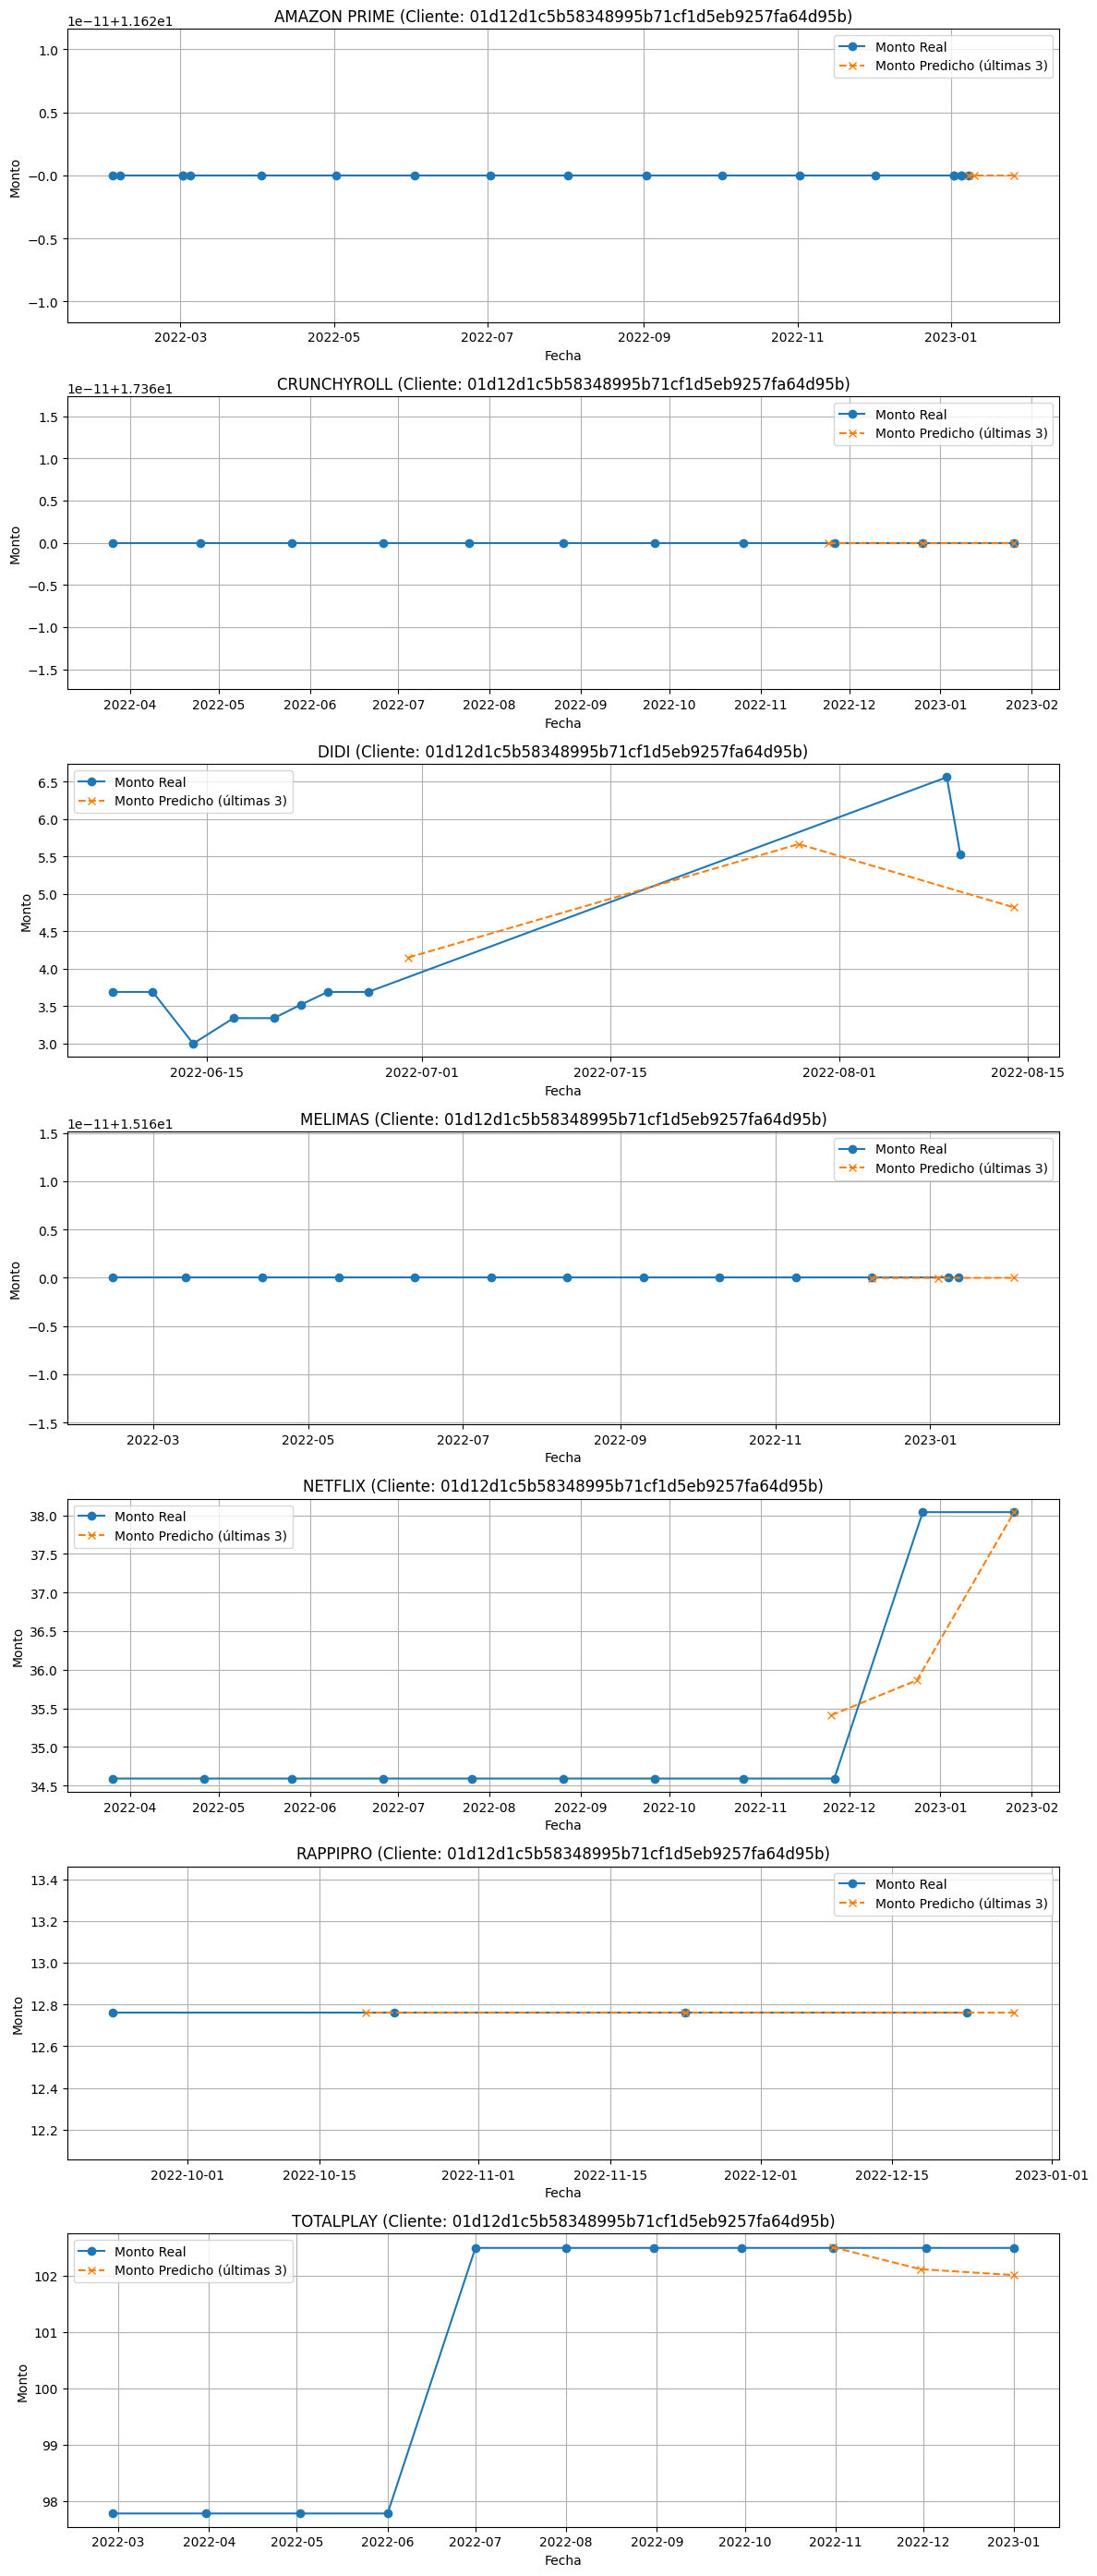

In [89]:
graficar_monto_real_vs_ultimas_predicciones("01d12d1c5b58348995b71cf1d5eb9257fa64d95b", df_comparacion_full)


In [79]:
def graficar_predicciones_por_cliente(cliente_id, df):
    empresas = df[df["cliente"] == cliente_id]["empresa"].unique()
    n = len(empresas)

    fig, axs = plt.subplots(n, 1, figsize=(12, 4 * n), sharex=False)

    if n == 1:
        axs = [axs]

    for i, empresa in enumerate(empresas):
        data = df[(df["cliente"] == cliente_id) & (df["empresa"] == empresa)]

        axs[i].plot(data["fecha_siguiente"], data["monto_siguiente"], label="Monto Real", marker='o')
        axs[i].plot(data["fecha_estimada"], data["monto_predicho"], label="Monto Predicho", marker='x', linestyle='--')

        axs[i].set_title(f"{empresa} (Cliente: {cliente_id})")
        axs[i].set_xlabel("Fecha")
        axs[i].set_ylabel("Monto")
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

In [142]:
# graficar_predicciones_por_cliente("01d12d1c5b58348995b71cf1d5eb9257fa64d95b", df_comparacion_full)